### Dependencies:

In [1]:
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql import DataFrame
from pyspark.sql.functions import format_number, when, col, array, udf, lit
import pandas as pd
from pyspark.ml.feature import VectorAssembler, StringIndexer, VectorIndexer, IndexToString
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml import Pipeline
from pyspark.sql.types import *
import pyspark.sql.functions as F
import matplotlib.pyplot as plt


### Initialize Spark:

In [2]:
spark = SparkSession.builder.appName("Project - Chicago crime")\
.config("spark.some.config.option", "some-value")\
.config("spark.driver.memory", "8g")\
.config("spark.driver.cores", "3")\
.getOrCreate()

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/04/13 17:51:03 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
crimes_schema = StructType([StructField("ID", StringType(), True),
                            StructField("Case Number", StringType(), True),
                            StructField("Date", StringType(), True ),
                            StructField("Block", StringType(), True),
                            StructField("IUCR", StringType(), True),
                            StructField("Primary Type", StringType(), True  ),
                            StructField("Description", StringType(), True ),
                            StructField("Location Description", StringType(), True ),
                            StructField("Arrest", BooleanType(), True),
                            StructField("Domestic", BooleanType(), True),
                            StructField("Beat", StringType(), True),
                            StructField("District", StringType(), True),
                            StructField("Ward", StringType(), True),
                            StructField("Community Area", StringType(), True),
                            StructField("FBI Code", StringType(), True ),
                            StructField("X Coordinate", DoubleType(), True),
                            StructField("Y Coordinate", DoubleType(), True ),
                            StructField("Year", IntegerType(), True),
                            StructField("Updated On", DateType(), True ),
                            StructField("Latitude", DoubleType(), True),
                            StructField("Longitude", DoubleType(), True),
                            StructField("Location", StringType(), True )
                            ])

### Read the data (csv file):

In [4]:
dataset =spark.read.option("header", "True")\
        .option("inferSchema", "true").csv("2018onwards/part-00000-0d2974f4-155b-44d2-94f5-4d3f46536b61-c000.csv")

In [5]:
dataset.printSchema()

root
 |-- Date: string (nullable = true)
 |-- Block: string (nullable = true)
 |-- Primary Type: string (nullable = true)
 |-- Location Description: string (nullable = true)
 |-- Arrest: boolean (nullable = true)
 |-- Beat: integer (nullable = true)
 |-- District: integer (nullable = true)
 |-- Ward: integer (nullable = true)
 |-- Community Area: integer (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Longitude: double (nullable = true)
 |-- Day: string (nullable = true)
 |-- Month: integer (nullable = true)
 |-- WeekDay: integer (nullable = true)



### Check the data and the schema:

In [7]:
dataset.limit(5).toPandas().head()

,Date,Block,Primary Type,Location Description,Arrest,Beat,District,Ward,Community Area,Year,Latitude,Longitude,Day,Month,WeekDay
0,03/17/2020 09:30:00 PM,039XX N LECLAIRE AVE,THEFT,STREET,False,1634,16,45,15,2020,41.952052,-87.754660,2020-03-17,3,3
1,09/24/2019 08:00:00 AM,022XX S MICHIGAN AVE,DECEPTIVE PRACTICE,COMMERCIAL / BUSINESS OFFICE,False,132,1,3,33,2019,41.852248,-87.623786,2019-09-24,9,3
2,10/13/2019 08:30:00 PM,024XX W CHICAGO AVE,THEFT,GROCERY FOOD STORE,False,1221,12,26,24,2019,41.895732,-87.687784,2019-10-13,10,1
3,03/18/2020 02:03:00 AM,039XX W JACKSON BLVD,MOTOR VEHICLE THEFT,APARTMENT,False,1132,11,28,26,2020,41.877110,-87.723990,2020-03-18,3,4
4,10/05/2019 06:30:00 PM,0000X N LOOMIS ST,THEFT,RESIDENCE,False,1224,12,27,28,2019,41.882002,-87.662287,2019-10-05,10,7


### 1. Only select data that after 2009.
### 2. Drop some crimes that are not important.

In [8]:
dataset=dataset.filter((dataset['Year'] >2009) & (dataset['Year'] !=2020))
dataset=dataset.filter((dataset['Primary Type']!='STALKING')&
                             (dataset['Primary Type']!='OBSCENITY')&
                             (dataset['Primary Type']!='NON-CRIMINAL (SUBJECT SPECIFIED)')&
                             (dataset['Primary Type']!='GAMBLING')&
                             (dataset['Primary Type']!='NON - CRIMINAL')&
                             (dataset['Primary Type']!='LIQUOR LAW VIOLATION')&
                             (dataset['Primary Type']!='PUBLIC INDECENCY')&
                             (dataset['Primary Type']!='HUMAN TRAFFICKING')&
                             (dataset['Primary Type']!='INTIMIDATION')&
                             (dataset['Primary Type']!='CONCEALED CARRY LICENSE VIOLATION')&
                             (dataset['Primary Type']!='NON-CRIMINAL')&
                             (dataset['Primary Type']!='OTHER NARCOTIC VIOLATION'))

### Extract Day, Month, WeekDay, Hour from Date column:

In [9]:
dataset=dataset.withColumn("Day", F.split(dataset.Date, " ")[0])
dataset=dataset.withColumn("Day", F.to_date(dataset.Day, "MM/dd/yyyy"))
dataset=dataset.withColumn("Month", F.month(dataset.Day))
dataset=dataset.withColumn("WeekDay", F.dayofweek(dataset.Day))
dataset=dataset.withColumn("Hour", F.split(F.split(dataset.Date," ")[1], ":")[0].cast("int"))
dataset=dataset.na.drop()
dataset.limit(5).toPandas().head()

,Date,Block,Primary Type,Location Description,Arrest,Beat,District,Ward,Community Area,Year,Latitude,Longitude,Day,Month,WeekDay,Hour
0,09/24/2019 08:00:00 AM,022XX S MICHIGAN AVE,DECEPTIVE PRACTICE,COMMERCIAL / BUSINESS OFFICE,False,132,1,3,33,2019,41.852248,-87.623786,2019-09-24,9,3,8
1,10/13/2019 08:30:00 PM,024XX W CHICAGO AVE,THEFT,GROCERY FOOD STORE,False,1221,12,26,24,2019,41.895732,-87.687784,2019-10-13,10,1,8
2,10/05/2019 06:30:00 PM,0000X N LOOMIS ST,THEFT,RESIDENCE,False,1224,12,27,28,2019,41.882002,-87.662287,2019-10-05,10,7,6
3,10/13/2019 07:00:00 PM,016XX W ADDISON ST,CRIMINAL DAMAGE,STREET,False,1922,19,47,6,2019,41.946987,-87.669164,2019-10-13,10,1,7
4,10/13/2019 02:10:00 PM,051XX N BROADWAY,ASSAULT,GAS STATION,False,2033,20,47,3,2019,41.975838,-87.659854,2019-10-13,10,1,2


### Check the number of crimes:

In [10]:
dataset.groupby('Primary Type').count().orderBy('count', ascending=False).show()

+--------------------+------+
|        Primary Type| count|
+--------------------+------+
|               THEFT|163492|
|             BATTERY|138031|
|     CRIMINAL DAMAGE| 83525|
|             ASSAULT| 65396|
|  DECEPTIVE PRACTICE| 49129|
|       OTHER OFFENSE| 47554|
| MOTOR VEHICLE THEFT| 46534|
|PUBLIC PEACE VIOL...| 30916|
|             ROBBERY| 26588|
|            BURGLARY| 25201|
|           NARCOTICS| 24174|
|   CRIMINAL TRESPASS| 16707|
|OFFENSE INVOLVING...|  6307|
|         SEX OFFENSE|  5750|
|CRIMINAL SEXUAL A...|  3827|
|            HOMICIDE|  2134|
|          KIDNAPPING|   395|
+--------------------+------+



### Drop all the invalid data:

In [11]:
dataset=dataset.na.drop()

### Check the number of crimes using bar chart:

Text(0, 0.5, 'Crime Type')

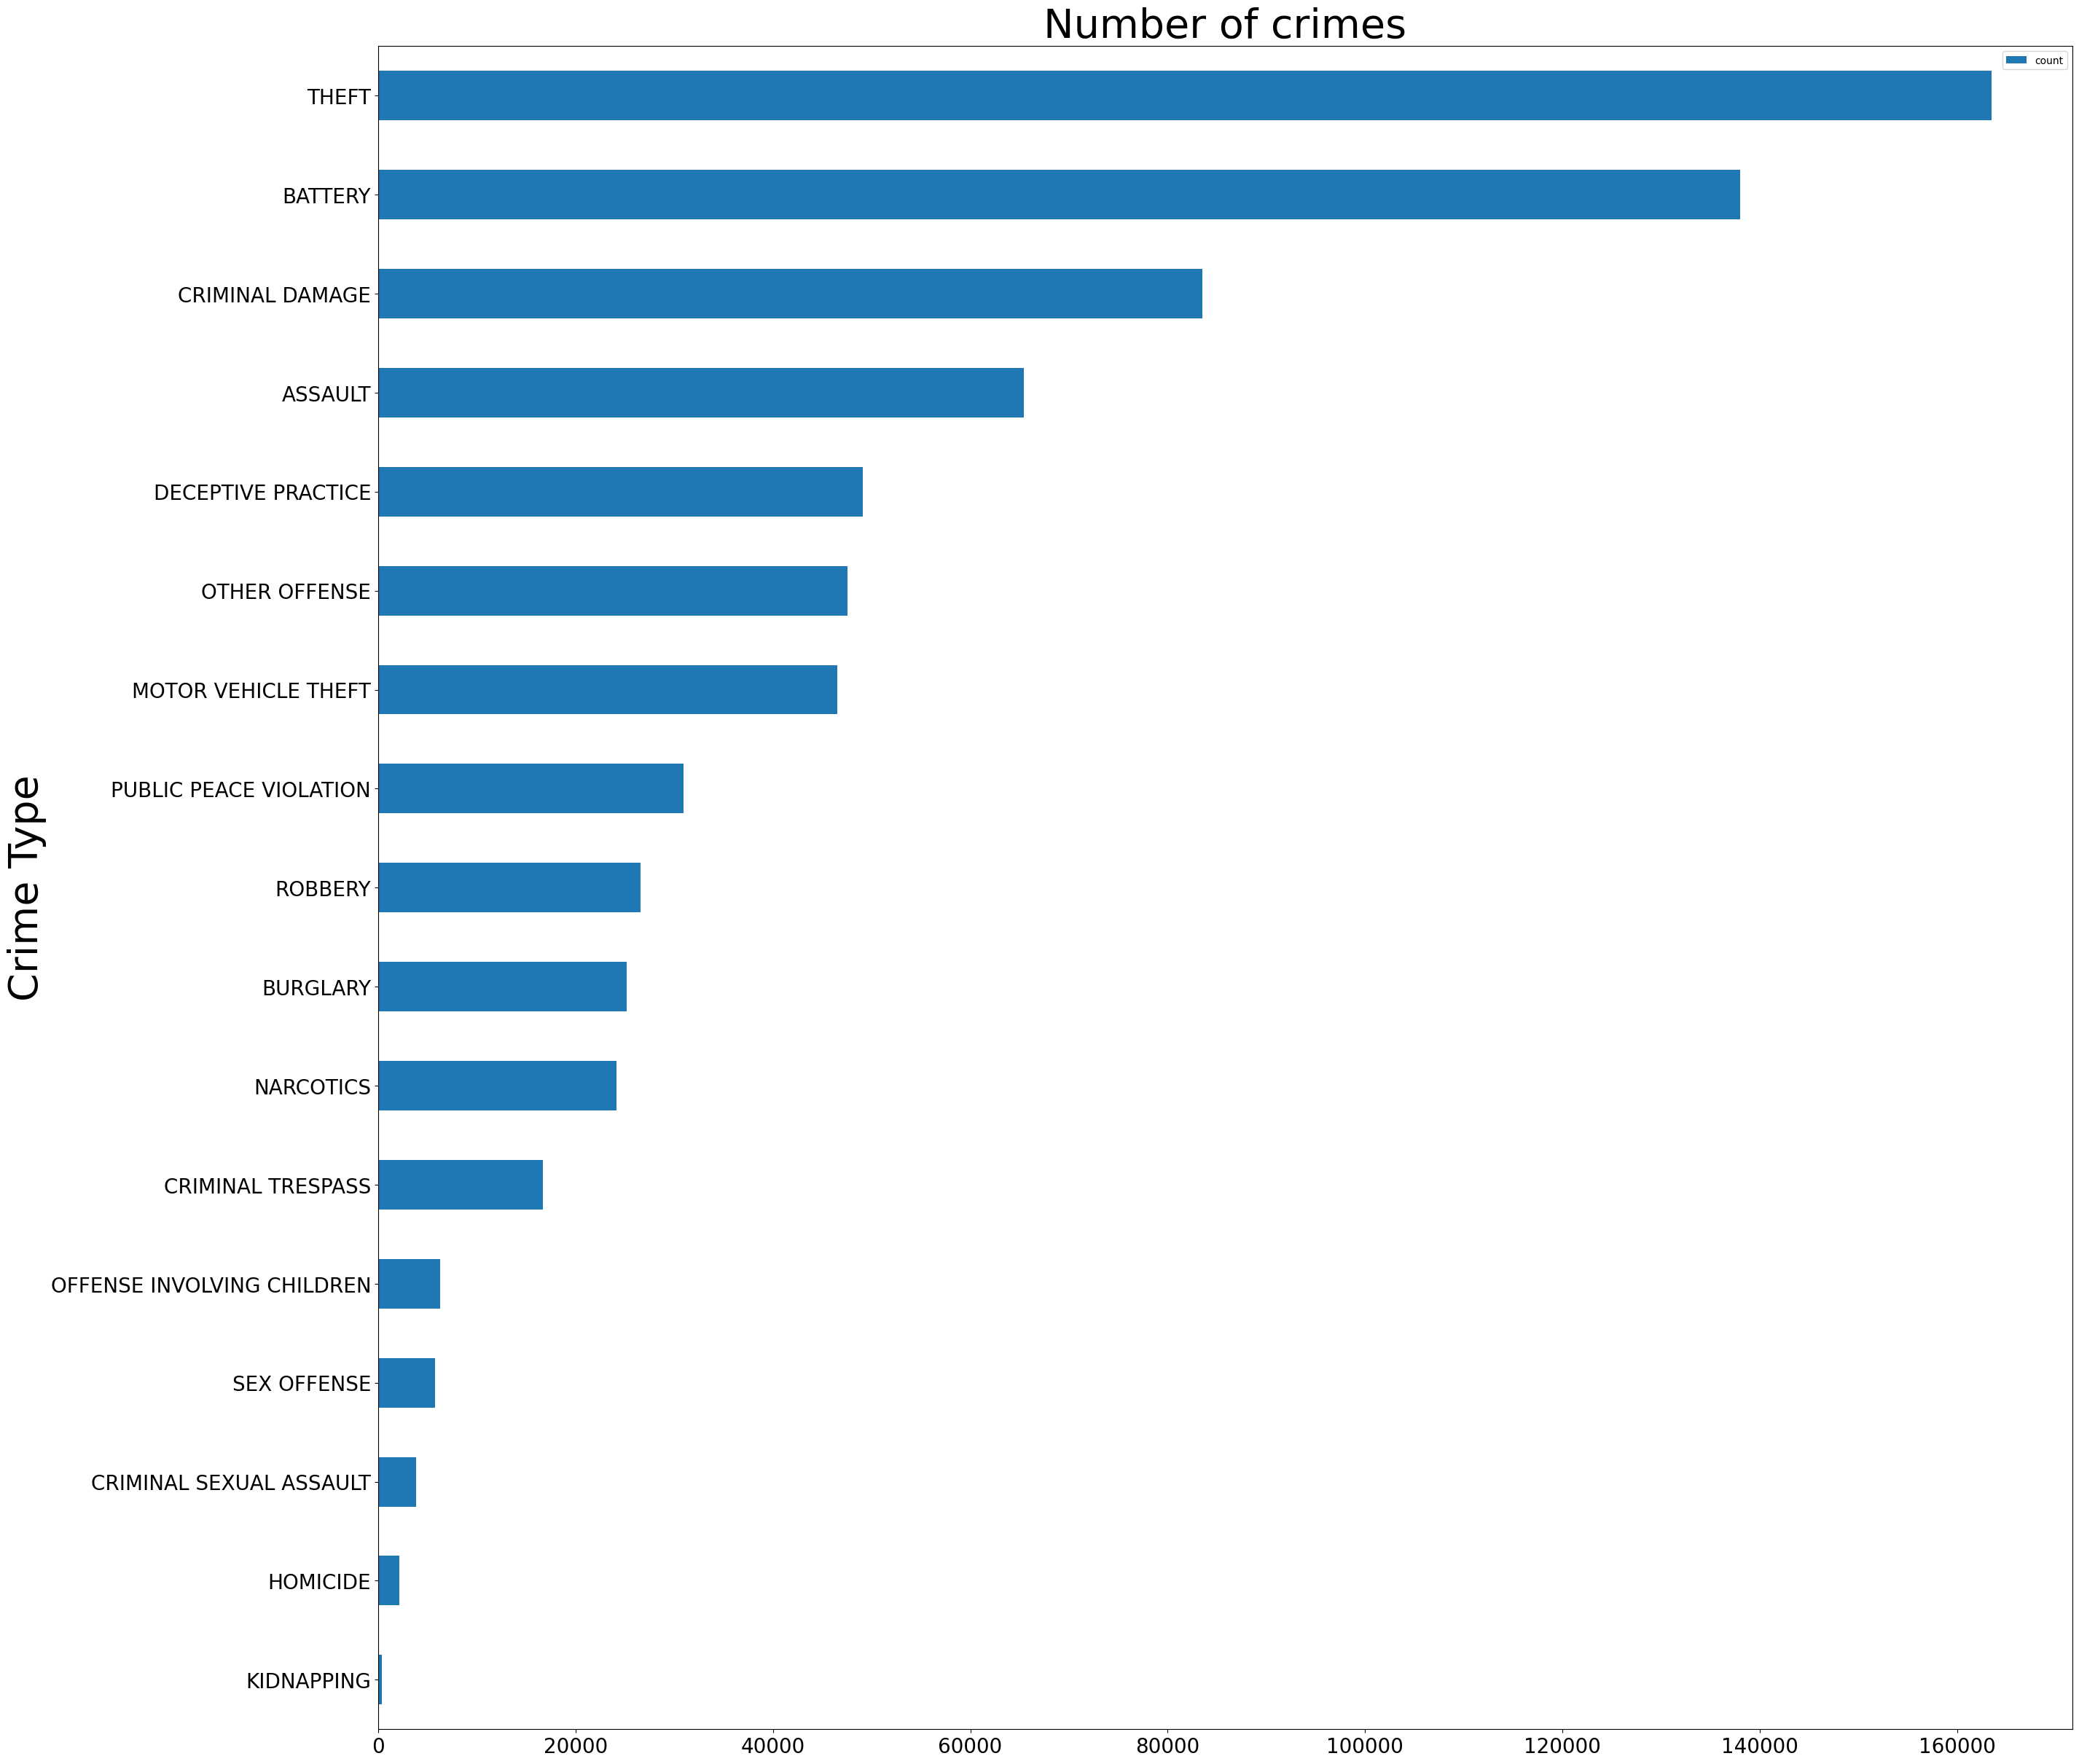

In [12]:
dataset.groupBy("Primary Type")\
        .count().toPandas().sort_values(by='count')\
        .plot(x='Primary Type',y='count',\
                      sort_columns=True,kind='barh', \
                      figsize=(30, 30),fontsize=20)
plt.title("Number of crimes", fontsize=40)
plt.ylabel('Crime Type', fontsize=40)

### List top 10 blocks that have most crimes:

Text(0.5, 0, 'Block Name')

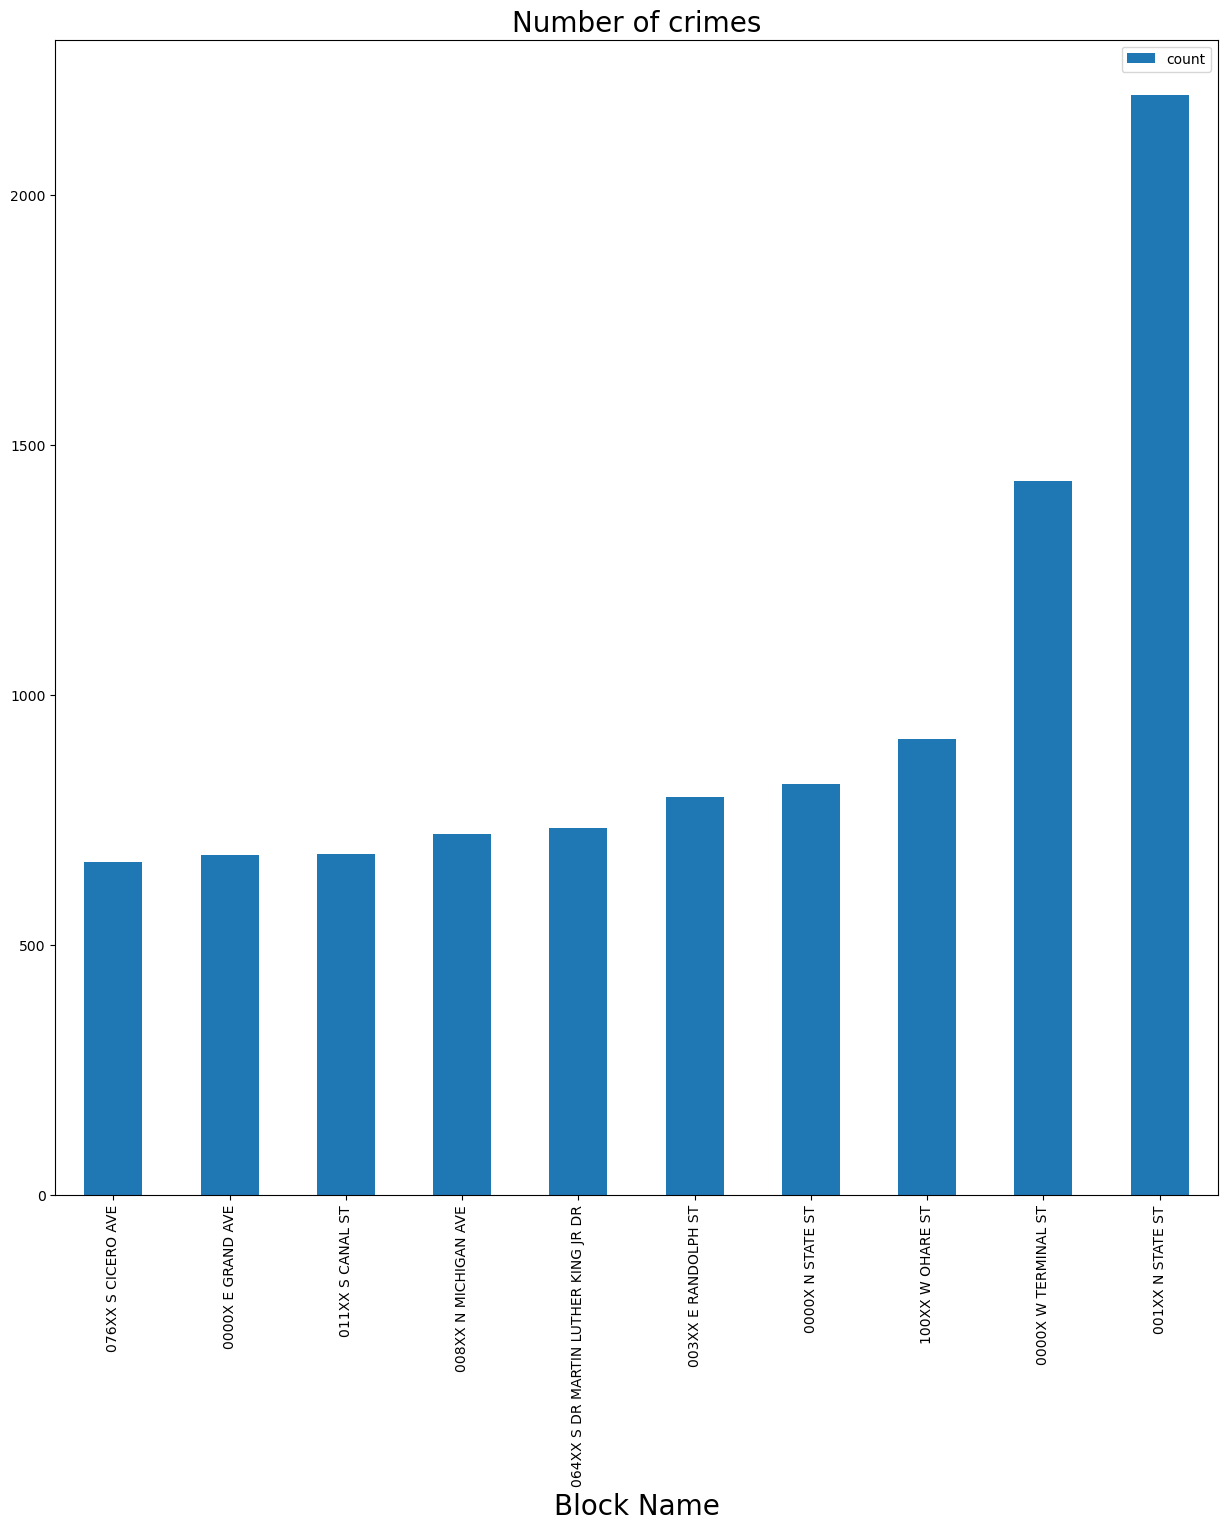

In [13]:
dataset.groupBy("Block")\
        .count().sort('count', ascending=False).limit(10)\
        .toPandas().sort_values(by='count')\
        .plot(x='Block',y='count',\
         sort_columns=True,kind='bar', \
         figsize=(15, 15),fontsize=10)
plt.title("Number of crimes", fontsize=20)
plt.xlabel('Block Name', fontsize=20)

### Using head map to check hot spot of crimes.
From heat map we can see that crimes have cluster pattern, so that we have the possibility to predict it.

In [14]:
import folium
from folium import plugins
from folium.plugins import HeatMap

latitude = 41.864073157
longitude = -87.706818608


heatMap = folium.Map(location=[latitude, longitude], 
                 tiles = "OpenStreetMap",
                zoom_start=12)
hotspot = dataset.toPandas().head(20000)
heat_data = [[row['Latitude'],row['Longitude']] for index, row in hotspot.iterrows()]
HeatMap(heat_data, radius=10).add_to(heatMap)

heatMap

## The following we will use Random Forest algorithm to train and test the model:

### Only use "Latitude" and "Longitude" as features:

In [15]:
vector_assembler = VectorAssembler(inputCols = ["Latitude", \
                            "Longitude"], outputCol="features")
df_temp = vector_assembler.transform(dataset)
featureIndexer =\
    VectorIndexer(inputCol="features", outputCol="indexedFeatures").fit(df_temp)


labelIndexer = StringIndexer(inputCol="Primary Type", outputCol="indexedLabel").fit(df_temp)
labelConverter = IndexToString(inputCol="prediction", outputCol="predictedLabel",
                               labels=labelIndexer.labels)


(trainingData, testData) = df_temp.randomSplit([0.7, 0.3])
rf = RandomForestClassifier(labelCol="indexedLabel", featuresCol="indexedFeatures", numTrees=100,impurity='gini', maxBins=128)

pipeline = Pipeline(stages=[labelIndexer, featureIndexer, rf,labelConverter])

model = pipeline.fit(trainingData)

predictions = model.transform(testData)
predictions.select("predictedLabel", "Primary Type").show()

evaluator = MulticlassClassificationEvaluator(
    labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")

evaluator2 = MulticlassClassificationEvaluator(
    labelCol="indexedLabel", predictionCol="prediction", metricName="f1")


accuracy = evaluator.evaluate(predictions)
f1 = evaluator2.evaluate(predictions)


print("accuracy = %g" % (accuracy))
print("f1 score = %g" % (f1))

predictions.groupBy("predictedLabel").count().show()

23/04/13 17:51:55 WARN DAGScheduler: Broadcasting large task binary with size 1014.2 KiB


+--------------+--------------------+
|predictedLabel|        Primary Type|
+--------------+--------------------+
|         THEFT|             BATTERY|
|         THEFT|               THEFT|
|         THEFT|  DECEPTIVE PRACTICE|
|       BATTERY|            BURGLARY|
|       BATTERY|PUBLIC PEACE VIOL...|
|       BATTERY|             BATTERY|
|       BATTERY|             BATTERY|
|       BATTERY|               THEFT|
|         THEFT|             BATTERY|
|       BATTERY|               THEFT|
|       BATTERY|             BATTERY|
|         THEFT|             BATTERY|
|         THEFT|             BATTERY|
|         THEFT|               THEFT|
|       BATTERY|             BATTERY|
|       BATTERY|     CRIMINAL DAMAGE|
|         THEFT|            BURGLARY|
|         THEFT|             ROBBERY|
|       BATTERY|             BATTERY|
|       BATTERY|     CRIMINAL DAMAGE|
+--------------+--------------------+
only showing top 20 rows



accuracy = 0.257741
f1 score = 0.15897


+---------------+------+
| predictedLabel| count|
+---------------+------+
|          THEFT| 90717|
|        BATTERY|125592|
|CRIMINAL DAMAGE|    64|
|      NARCOTICS|  4702|
+---------------+------+



In [17]:
# Get the confusion matrix
labels = predictions.select(col("indexedLabel")).distinct().rdd.flatMap(lambda x: x).collect()
cm = predictions.groupBy("indexedLabel", "prediction").count().orderBy("indexedLabel", "prediction")
cm.show()

+------------+----------+-----+
|indexedLabel|prediction|count|
+------------+----------+-----+
|         0.0|       0.0|29152|
|         0.0|       1.0|19531|
|         0.0|       2.0|    5|
|         0.0|      10.0|  530|
|         1.0|       0.0|13758|
|         1.0|       1.0|26651|
|         1.0|       2.0|    6|
|         1.0|      10.0|  841|
|         2.0|       0.0| 9043|
|         2.0|       1.0|15771|
|         2.0|       2.0|   45|
|         2.0|      10.0|  391|
|         3.0|       0.0| 6507|
|         3.0|       1.0|12839|
|         3.0|      10.0|  326|
|         4.0|       0.0| 8537|
|         4.0|       1.0| 5937|
|         4.0|       2.0|    2|
|         4.0|      10.0|  183|
|         5.0|       0.0| 5107|
+------------+----------+-----+
only showing top 20 rows



### Use all the availbel features: "Latitude", "Longitude", "Arrest", "Beat", "Ward","Community Area","WeekDay","Hour"

In [18]:
vector_assembler = VectorAssembler(inputCols = ["Latitude", "Longitude", "Arrest", "Beat", "Ward","WeekDay","Hour"], outputCol="features")
df_temp = vector_assembler.transform(dataset)
featureIndexer =\
    VectorIndexer(inputCol="features", outputCol="indexedFeatures").fit(df_temp)


labelIndexer = StringIndexer(inputCol="Primary Type", outputCol="indexedLabel").fit(df_temp)
labelConverter = IndexToString(inputCol="prediction", outputCol="predictedLabel",
                               labels=labelIndexer.labels)


(trainingData, testData) = df_temp.randomSplit([0.7, 0.3])
rf = RandomForestClassifier(labelCol="indexedLabel", featuresCol="indexedFeatures", numTrees=10,impurity='gini', maxBins=32)

pipeline = Pipeline(stages=[labelIndexer, featureIndexer, rf,labelConverter])

model = pipeline.fit(trainingData)

predictions = model.transform(testData)
predictions.select("predictedLabel", "Primary Type").show()

evaluator = MulticlassClassificationEvaluator(
    labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")

evaluator2 = MulticlassClassificationEvaluator(
    labelCol="indexedLabel", predictionCol="prediction", metricName="f1")


accuracy = evaluator.evaluate(predictions)
f1 = evaluator2.evaluate(predictions)


print("accuracy = %g" % (accuracy))
print("f1 score = %g" % (f1))

predictions.groupBy("predictedLabel").count().show()

+--------------------+--------------------+
|      predictedLabel|        Primary Type|
+--------------------+--------------------+
|               THEFT|               THEFT|
|             BATTERY|            BURGLARY|
|               THEFT|               THEFT|
|PUBLIC PEACE VIOL...|PUBLIC PEACE VIOL...|
|               THEFT|               THEFT|
|           NARCOTICS|             BATTERY|
|           NARCOTICS|           NARCOTICS|
|             BATTERY|PUBLIC PEACE VIOL...|
|               THEFT|       OTHER OFFENSE|
|PUBLIC PEACE VIOL...|             ASSAULT|
|             BATTERY|     CRIMINAL DAMAGE|
|               THEFT|             BATTERY|
|               THEFT|             BATTERY|
|               THEFT|               THEFT|
|               THEFT|             BATTERY|
|               THEFT|         SEX OFFENSE|
|               THEFT|             BATTERY|
|               THEFT|             BATTERY|
|               THEFT|             BATTERY|
|               THEFT|     CRIMI

accuracy = 0.268393
f1 score = 0.17549


+--------------------+------+
|      predictedLabel| count|
+--------------------+------+
|PUBLIC PEACE VIOL...|  7439|
|               THEFT|102441|
|             BATTERY|101748|
|           NARCOTICS|  8840|
+--------------------+------+



### Encoding "Location description":

In [ ]:
print(predictions)

In [19]:
from pyspark.ml.feature import OneHotEncoder
locationIndexer = StringIndexer(inputCol="Location Description", outputCol="indexedLocation")\
                .fit(dataset)\
                .transform(dataset)
encoded_data = OneHotEncoder(inputCols=["indexedLocation"],outputCols=["encodedLocation"])\
        .fit(locationIndexer)\
        .transform(locationIndexer)

### Add "encodedLocation" to model:

In [20]:
vector_assembler = VectorAssembler(inputCols = ["Latitude", "Longitude", "Arrest", "Beat", "Ward","Community Area","WeekDay","Hour","encodedLocation"], outputCol="features")
df_temp = vector_assembler.transform(encoded_data)
featureIndexer =\
    VectorIndexer(inputCol="features", outputCol="indexedFeatures").fit(df_temp)


labelIndexer = StringIndexer(inputCol="Primary Type", outputCol="indexedLabel").fit(df_temp)
labelConverter = IndexToString(inputCol="prediction", outputCol="predictedLabel",
                               labels=labelIndexer.labels)


(trainingData, testData) = df_temp.randomSplit([0.7, 0.3])
rf = RandomForestClassifier(labelCol="indexedLabel", featuresCol="indexedFeatures", numTrees=10,impurity='gini', maxBins=32)

pipeline = Pipeline(stages=[labelIndexer, featureIndexer, rf,labelConverter])

model = pipeline.fit(trainingData)

predictions = model.transform(testData)
predictions.select("predictedLabel", "Primary Type").show()

evaluator = MulticlassClassificationEvaluator(
    labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")

evaluator2 = MulticlassClassificationEvaluator(
    labelCol="indexedLabel", predictionCol="prediction", metricName="f1")


accuracy = evaluator.evaluate(predictions)
f1 = evaluator2.evaluate(predictions)


print("accuracy = %g" % (accuracy))
print("f1 score = %g" % (f1))

predictions.groupBy("predictedLabel").count().show()

+--------------+------------------+
|predictedLabel|      Primary Type|
+--------------+------------------+
|         THEFT|           BATTERY|
|         THEFT|             THEFT|
|       BATTERY|          BURGLARY|
|         THEFT|DECEPTIVE PRACTICE|
|       BATTERY|   CRIMINAL DAMAGE|
|         THEFT|           BATTERY|
|         THEFT|             THEFT|
|         THEFT|           BATTERY|
|         THEFT|             THEFT|
|         THEFT|           BATTERY|
|       BATTERY|           BATTERY|
|         THEFT|DECEPTIVE PRACTICE|
|         THEFT|             THEFT|
|       BATTERY|   CRIMINAL DAMAGE|
|       BATTERY|           ASSAULT|
|       BATTERY|           ASSAULT|
|         THEFT|           ROBBERY|
|       BATTERY|          BURGLARY|
|         THEFT|             THEFT|
|         THEFT|           BATTERY|
+--------------+------------------+
only showing top 20 rows



accuracy = 0.283804
f1 score = 0.164774


+------------------+------+
|    predictedLabel| count|
+------------------+------+
|             THEFT|139258|
|           BATTERY| 80859|
|DECEPTIVE PRACTICE|   225|
+------------------+------+



### Using a grid search, 4-fold cross validation, and change to pipeline runner, finally get the best parameter:

In [ ]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

vector_assembler = VectorAssembler(inputCols = ["Latitude", \
                            "Longitude", "Arrest", "Beat", "Ward","Community Area","WeekDay","Hour","encodedLocation"], outputCol="features")


indexed_data = vector_assembler.transform(encoded_data)
featureIndexer =\
    VectorIndexer(inputCol="features", outputCol="indexedFeatures").fit(indexed_data)


labelIndexer = StringIndexer(inputCol="Primary Type", outputCol="indexedLabel").fit(indexed_data)
labelConverter = IndexToString(inputCol="prediction", outputCol="predictedLabel",
                               labels=labelIndexer.labels)


(trainingData, testData) = indexed_data.randomSplit([0.7, 0.3])
rf = RandomForestClassifier(labelCol="indexedLabel", featuresCol="indexedFeatures")

pipeline = Pipeline(stages=[labelIndexer, featureIndexer, rf,labelConverter])

paramGrid = ParamGridBuilder()\
            .addGrid(rf.numTrees, [3,10])\
            .addGrid(rf.maxBins, [32,64])\
            .addGrid(rf.maxDepth, [5,10])\
            .addGrid(rf.impurity,['gini','entropy'])\
            .build()

evaluator = MulticlassClassificationEvaluator(
    labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")

crossval = CrossValidator(\
                          estimator=pipeline,\
                         estimatorParamMaps=paramGrid,\
                         evaluator=evaluator,\
                         numFolds=4)


model = crossval.fit(trainingData)


predictions = model.transform(testData)
predictions.select("predictedLabel", "Primary Type").show()

evaluator2 = MulticlassClassificationEvaluator(
    labelCol="indexedLabel", predictionCol="prediction", metricName="f1")
accuracy = evaluator.evaluate(predictions)
f1 = evaluator2.evaluate(predictions)
print("accuracy = %g" % (accuracy))
print("f1 score = %g" % (f1))

predictions.groupBy("predictedLabel").count().show()

bestPipeline = model.bestModel
bestLRModel = bestPipeline.stages[2]
bestParams = bestLRModel.extractParamMap()
print("\n".join("{}\t{}".format(k, v) for k, v in bestParams.items()))



### Get the probability of each test data:

In [21]:
labels = labelIndexer.labels
prediction_probility= predictions.select("predictedLabel", "Primary Type","Latitude","Longitude","probability")

def addCrimeIndex(li):
    dic = {}
    for i in range(len(labels)):
        dic[labels[i]]=li[i];
    return dic

probability_to_array = udf(lambda v: v.toArray().tolist(), ArrayType(FloatType()))
prediction_probility = prediction_probility.withColumn('probability', probability_to_array(prediction_probility.probability))

probability_to_dict = udf(addCrimeIndex)

prediction_probility = prediction_probility.withColumn('probability', probability_to_dict(prediction_probility.probability))

pd.set_option('display.max_colwidth', -1)
prediction_probility.limit(20).toPandas().head(7)

/tmp/ipykernel_5788/3477220655.py:17: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


,predictedLabel,Primary Type,Latitude,Longitude,probability
0,THEFT,BATTERY,41.898003,-87.628771,"{HOMICIDE=0.001619379152305455, BATTERY=0.21217281699167817, ROBBERY=0.06523539699051312, SEX OFFENSE=0.009542723090140651, OFFENSE INVOLVING CHILDREN=0.004557387136264834, CRIMINAL SEXUAL ASSAULT=0.004746111063918625, NARCOTICS=0.08220202037785955, CRIMINAL TRESPASS=0.0245886881665581, CRIMINAL DAMAGE=0.06602065659756776, DECEPTIVE PRACTICE=0.0549978398795846, OTHER OFFENSE=0.04201485984080368, PUBLIC PEACE VIOLATION=0.06375266662729048, ASSAULT=0.09007990837165239, MOTOR VEHICLE THEFT=0.03217827188086481, KIDNAPPING=8.378191506283664E-4, BURGLARY=0.020199197066292467, THEFT=0.22525425761607698}"
1,THEFT,THEFT,41.893652,-87.622726,"{HOMICIDE=0.002307773263966992, BATTERY=0.16542590025779033, ROBBERY=0.03901621903371062, SEX OFFENSE=0.007661171100886625, OFFENSE INVOLVING CHILDREN=0.00506542470822654, CRIMINAL SEXUAL ASSAULT=0.006150451810666092, NARCOTICS=0.020756754159191964, CRIMINAL TRESPASS=0.027387058733149994, CRIMINAL DAMAGE=0.10501777554138148, DECEPTIVE PRACTICE=0.07276062114085878, OTHER OFFENSE=0.048432122711538954, PUBLIC PEACE VIOLATION=0.03101209973956609, ASSAULT=0.08107658342418861, MOTOR VEHICLE THEFT=0.06156944841050016, KIDNAPPING=4.668381110033076E-4, BURGLARY=0.031182202457839637, THEFT=0.29471155539553406}"
2,BATTERY,BURGLARY,41.794353,-87.734225,"{HOMICIDE=0.0020762033101701487, BATTERY=0.1997000941000145, ROBBERY=0.026181209165414165, SEX OFFENSE=0.00955079082922065, OFFENSE INVOLVING CHILDREN=0.015890636846117065, CRIMINAL SEXUAL ASSAULT=0.00551742195738218, NARCOTICS=0.028896764080024645, CRIMINAL TRESPASS=0.022393612126104495, CRIMINAL DAMAGE=0.1179782987776683, DECEPTIVE PRACTICE=0.09859257178223944, OTHER OFFENSE=0.0928625271837967, PUBLIC PEACE VIOLATION=0.03284351245493662, ASSAULT=0.09000514690330796, MOTOR VEHICLE THEFT=0.04367399308981255, KIDNAPPING=6.119324885958587E-4, BURGLARY=0.042371675376804994, THEFT=0.17085360952838974}"
3,THEFT,DECEPTIVE PRACTICE,41.675253,-87.601696,"{HOMICIDE=0.0030909001675624307, BATTERY=0.1675721421903263, ROBBERY=0.03536986057356652, SEX OFFENSE=0.008334082375010505, OFFENSE INVOLVING CHILDREN=0.007464168288758284, CRIMINAL SEXUAL ASSAULT=0.004224363667989654, NARCOTICS=0.030900058964971944, CRIMINAL TRESPASS=0.02507844644051244, CRIMINAL DAMAGE=0.11111358169505862, DECEPTIVE PRACTICE=0.07774958391587802, OTHER OFFENSE=0.06564304870444261, PUBLIC PEACE VIOLATION=0.04192568793590618, ASSAULT=0.08820212532801333, MOTOR VEHICLE THEFT=0.06298128527337407, KIDNAPPING=4.858127241741818E-4, BURGLARY=0.03163793923856131, THEFT=0.23822691251589395}"
4,BATTERY,CRIMINAL DAMAGE,41.750800,-87.575962,"{HOMICIDE=0.0020116298374255694, BATTERY=0.19950173211024191, ROBBERY=0.02615492829173082, SEX OFFENSE=0.009106702690323055, OFFENSE INVOLVING CHILDREN=0.015687064854209697, CRIMINAL SEXUAL ASSAULT=0.005580358536610264, NARCOTICS=0.023860157519449574, CRIMINAL TRESPASS=0.02265609234964783, CRIMINAL DAMAGE=0.11796883993731266, DECEPTIVE PRACTICE=0.09876179863705946, OTHER OFFENSE=0.09189006851821117, PUBLIC PEACE VIOLATION=0.03275547279276976, ASSAULT=0.09014098367696599, MOTOR VEHICLE THEFT=0.044031697529216894, KIDNAPPING=6.057945934236394E-4, BURGLARY=0.04214666067124674, THEFT=0.17714001745415517}"
5,THEFT,BATTERY,41.866492,-87.697452,"{HOMICIDE=0.004481655569780715, BATTERY=0.1537297364701496, ROBBERY=0.04373395075893124, SEX OFFENSE=0.007352720617329127, OFFENSE INVOLVING CHILDREN=0.00558653089985982, CRIMINAL SEXUAL ASSAULT=0.0034881437151805302, NARCOTICS=0.03974703642795912, CRIMINAL TRESPASS=0.01902813856562745, CRIMINAL DAMAGE=0.12820044982325712, DECEPTIVE PRACTICE=0.04545362670047706, OTHER OFFENSE=0.05473749290496547, PUBLIC PEACE VIOLATION=0.05591111937974639, ASSAULT=0.08389804655385469, MOTOR VEHICLE THEFT=0.10409643995110712, KIDNAPPING=5.444814831547829E-4, BURGLARY=0.02284960886149563, THEFT=0.22716082131712367}"
6,THEFT,THEFT,41.875273,-87.624251,"{HOMICIDE=0.0